By this point, your data calibration should be nearly complete! Make sure to subtract off your sky background before moving onto flux extraction.

In [1]:
import numpy as np
import specsuite as ss
import matplotlib.pyplot as plt

# Defines where to look for data
DATA_REGION = (700, 800)
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
INSTRUMENT = "kosmos"

# Collects all the necessary exposures
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT
)

flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

arclamp = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

science = ss.collect_images_array(
    DATA_PATH,
    "toi3884",
    crop_bds=DATA_REGION,
    instrument = INSTRUMENT,
) - bias

### Performs a flatfield correction
science = ss.flatfield_correction(science, flat)

### Extracts background emissions
locs, _ = ss.find_cal_lines(arclamp, std_variation=200)
warp_model = ss.generate_warp_model(arclamp, locs)
backgrounds = ss.extract_background(science, warp_model, mask_region=(40, 80))

science -= backgrounds

## **Basic Usage**
As of now, there are only two available methods for extracting flux from your science exposure.

### _Boxcar Extraction_
Let **D**(x, y) represent a single background-contaminated exposure where the values at every point has units of photo-electrons. Similarly, let **S**(x, y) represent the strength of the background across the image (also in units of photo-electrons). The simplest possible estimate of our signal is known as a *boxcar extraction* where...

\begin{equation*}
    f(x) = \sum_{i} \left[ \textbf{D}(x, y_i) - \textbf{S}(x, y_i) \right]
\end{equation*}

is the extracted flux. The uncertainty of this signal is given by...

\begin{equation*}
    \sigma(x) = \sqrt{RN^2 + \sum_{i} \textbf{D}(x, y_i)}
\end{equation*}

where RN is the "read noise" of the detector. This is a quick and simple extraction method, but has several noteable drawbacks. Firstly, if cosmic ray contamination is present in your data, then the extracted flux will have erroneous and sudden jumps in brigthness for dispersion-axis pixels with any level of contamination. Secondly, the uncertainty of your extracted spectra is artificially inflated by dimly-illuminated regions of your detector.

Despite these issues, it can be a useful for first looks! Here is a simple example call for our KOSMOS data...

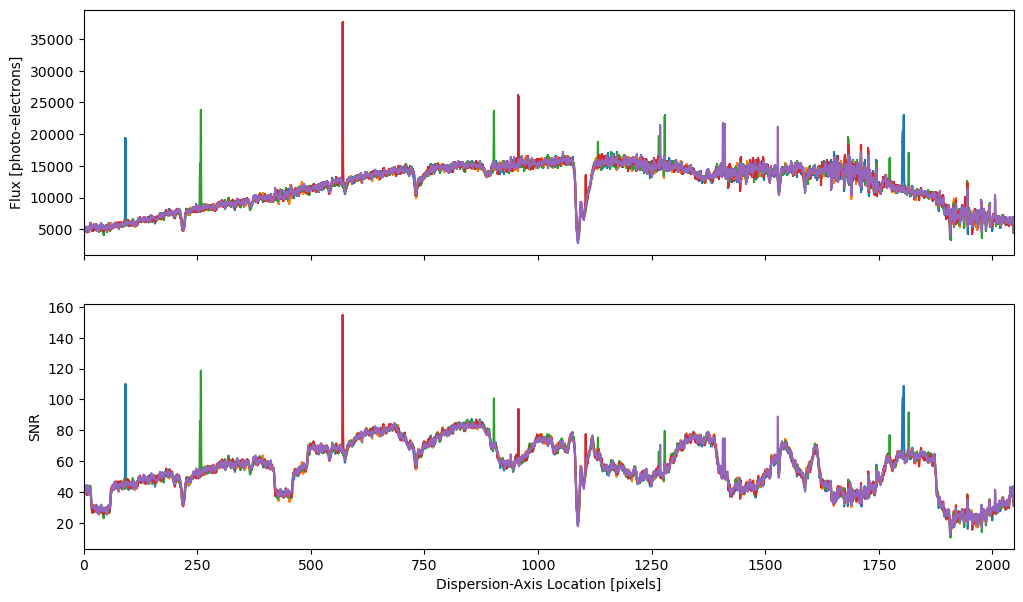

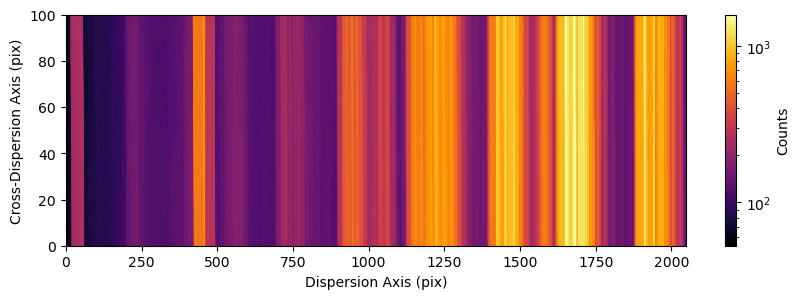

In [ ]:
import warnings

#boxcar_flux, boxcar_errs = boxcar_extraction(np.array([]), np.array([]))

boxcar_flux, boxcar_errs = boxcar_extraction(science, backgrounds, RN=6.0)

pixel_location = np.array(range(len(boxcar_flux[0])))

fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
for idx in range(len(boxcar_flux)):
    axs[0].errorbar(pixel_location, boxcar_flux[idx], yerr=boxcar_errs[idx])
    axs[1].plot(pixel_location, boxcar_flux[idx]/boxcar_errs[idx])

axs[0].set_xlim(min(pixel_location), max(pixel_location))
axs[0].set_ylabel("Flux [photo-electrons]")
axs[1].set_ylabel("SNR")
axs[1].set_xlabel("Dispersion-Axis Location [pixels]")
plt.show()

ss.plot_image(backgrounds[0], norm='log')

Notice the prominant cosmic ray contamination and poor SNR for dispersion-axis pixels with a strong background emission. While neither can be entirely corrected for, the next extraction method uses a statistical argument to mitigate both of these non-ideal features.

### _What is Horne's (Optimal) Extraction?_
**Horne's extraction routine** uses an iterative process to revise its estimate of the variance (**V**(x, y)) until an optimal SNR is reached. Please refer to **[Horne (1986)](https://articles.adsabs.harvard.edu/pdf/1986PASP...98..609H)** for a complete discussion of this process. One important component of the optimal extraction routine is the spatial profile **P**. This profile describes how likely a photon from a point-source target is to land at any pixel along the cross-dispersion axis.

We assume that each trace profile is approximately Gaussian, and the mean and standard deviation smoothly shifts along the cross-dispersion direction. If our signal was bright and had no cosmic ray contamination, we could simply fit a Gaussian to each column. Unfortunately, nearly all data is too noisy or faint for this to work.

In ```horne_extraction()```, this problem is addressed using a useful signal processing technique. The cross-correlation of two (unnormalized) Gaussians is another (unnormalized) Gaussian where...

\begin{equation*}
f(y) = A \cdot \left[-\frac{1}{2} \left( \frac{\mu_1 + \mu_2 - y}{\sqrt{\sigma_1^2 + \sigma_2^2}} \right)^2 \right].
\end{equation*}

We cross-correlate each column by a Gaussian with a generated mean and standard deviation, then fit a Gaussian to the points with the greatest correlation. This allows us to estimate the original signal's location and spread! A low-order polynomial is fit to these means and standard deviations to predict the profile location and spread along the dispersion axis.

### _Finding a Spatial Profile_
The simplest method available for generating a spatial profile requires an image and the name of the profile to load...

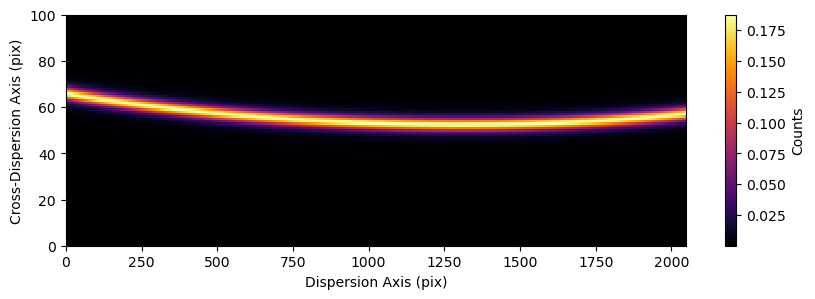

In [3]:
P = ss.generate_spatial_profile(
    image = science[0],
    profile="moffat",
)

ss.plot_image(P)

This step of the reduction can be a little finicky, especially for particularly noisy data with significant cosmic ray contamination. We attempt to address this by using a couple of non-ideal assumptions.

<div class="admonition information">
    <p class="admonition-title">Information</p>
    <p>
        For ground-based data, a Gaussian spatial profile is usually inaccurate. This is due to atmospheric effects blurring and is most significant for the wings of the profile. Although we use 
    </p>
</div>

<div class="admonition warning">
    <p class="admonition-title">Warning</p>
    <p>
        The Moffat profile used in <span class="specsuite-text"><code>specsuite</code></span>'s reduction is not completely accurate. For reference, the Moffat profile adopted by <a href="https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Moffat1D.html"><strong>astropy</strong></a> is...
        \begin{equation}
        f(x) = A \left[ \frac{(x - x_0)^2}{\gamma^2} \right]^{-\alpha}.
        \end{equation}
        If gamma and alpha were both left as free parameters, we found that fits struggled to converge to a single, consistent answer. We address this by setting alpha to a constant (2.5). This choice is arbitrary, but we have found that it consistently results in a higher quality of fit.
    </p>
</div>

### Semi-Optimal Extraction
In Horne's optimal extraction algorithm, the flux is given by...
$$
\begin{equation}
f(x) = \frac{\sum_y \textbf{M} \textbf{P} (\textbf{D} - \textbf{S}) / \textbf{V}}{\sum_y \textbf{M} \textbf{P}^2 / \textbf{V}}
\end{equation}
$$
with a variance...
$$
\begin{equation}
\text{var}[f](x) = \frac{\sum_y \textbf{M} \textbf{P}}{\sum_y \textbf{M} \textbf{P}^2 / \textbf{V}}.
\end{equation}
$$
We decided to remove the outlier masking during our extraction. This means that cosmic ray contamination (and any other source of outliers) will no longer be de-weigthed. Although we intend to make this extraction method more robust in future releases, this is the state of our flux extraction capabilities.

Performing Optimal Extraction: 100%|██████████| 1/1 [00:12<00:00, 12.64s/it]


<ErrorbarContainer object of 3 artists>

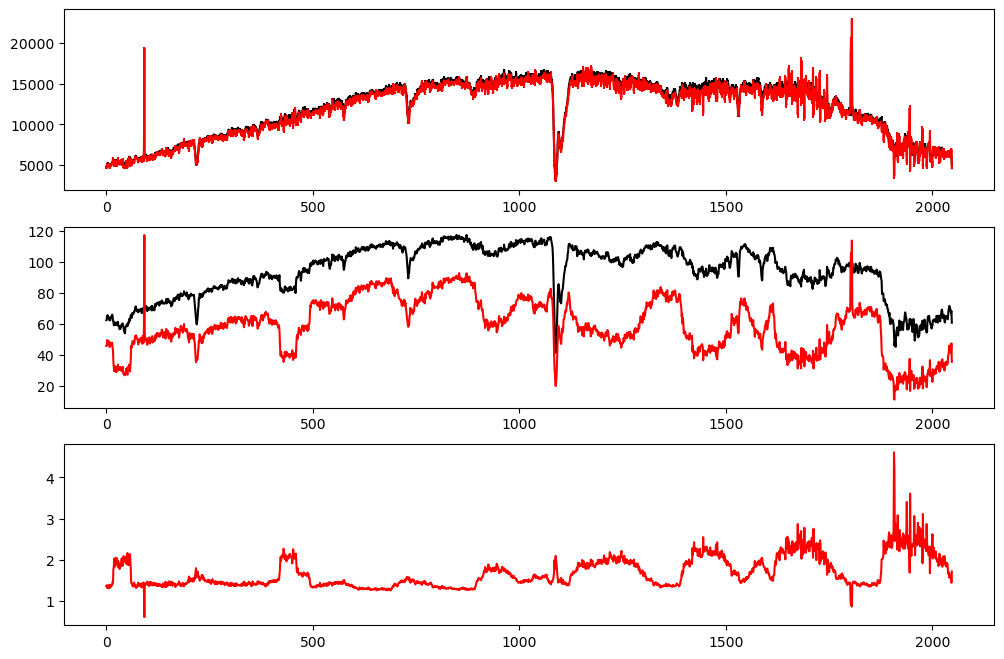

In [ ]:
optimal_flux, optimal_err = ss.horne_extraction(
    images = science[0],
    backgrounds = backgrounds[0],
    profile = "moffat",
    RN = 0,
    update=True,
)

# xs = np.array(range(len(optimal_flux.T[0])))

# fig, axs = plt.subplots(3, 1, figsize=(12, 8))

# axs[0].errorbar(xs, optimal_flux.T[0], yerr=optimal_err.T[0], color='k')
# axs[0].errorbar(xs, boxcar_flux[0], yerr=boxcar_errs[0], color='red')
# axs[1].plot(xs, optimal_flux.T[0]/optimal_err.T[0], color='k')
# axs[1].plot(xs, boxcar_flux[0]/boxcar_errs[0], color='red')

# axs[2].errorbar(xs, (optimal_flux.T[0]/optimal_err.T[0]) / (boxcar_flux[0]/boxcar_errs[0]), color='red')

## __Common Errors__

### Errors seem a little high / low

Both ```boxcar_extraction()``` and ```horne_extraction()``` assume that RN=6 and gain=0.6. These values are only accurate for APO's KOSMOS instrument, but can easily be adjusted by providing the correct values for your spectrograph...

Performing Optimal Extraction: 100%|██████████| 5/5 [01:04<00:00, 12.91s/it]


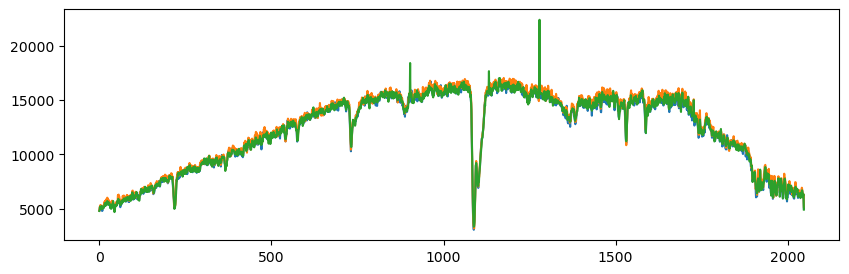

In [5]:
flux, err = ss.horne_extraction(
    images = science,
    backgrounds = backgrounds,
    profile = "moffat",
    RN = 6,
    max_iter = 5,
    update=True,
)

plt.plot(flux.T[0])
plt.plot(flux.T[1])
plt.plot(flux.T[2])

### Extracted SED is slightly misshapen
We assume that your ```images``` have already been background-subtracted. If that is not the case, make sure to do so beforehand...

In [6]:
flux, err = ss.horne_extraction(science + backgrounds, backgrounds)
ss.plot_spectra(flux, err)

AttributeError: module 'specsuite' has no attribute 'plot_spectra'